**1. Import**

In [ ]:
# path = '/content/drive/MyDrive/Kaggle/speech_recognition/'
path = '/content/gdrive/MyDrive/speech_recognition/'
classes = ['yes', 'no', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'up', 'down']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**2. Creating the dataset**

In [ ]:
import os
import tensorflow as tf
import soundfile as sf
import numpy as np
import librosa

tf_dic_train = {}
tf_dic_val = {}
tf_dic_test = {}
FILES_TO_LOAD = 500

# Read file names from testing_list.txt and validation_list.txt
with open(os.path.join(path, "testing_list.txt"), 'r') as file:
    test_names = file.read().splitlines()
with open(os.path.join(path, "validation_list.txt"), 'r') as file:
    val_names = file.read().splitlines()

for i, label in enumerate(classes):
    train_tmp = []
    val_tmp = []
    test_tmp = []
    for filename in os.listdir(os.path.join(path, label)):
        file_path = os.path.join(path, label, filename)
        if "/".join([label, filename]) in test_names:
            if len(test_tmp) >= FILES_TO_LOAD * 0.1:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                test_tmp.append(librosa.feature.melspectrogram(y=audio, sr=sample_rate, hop_length=512))
        elif "/".join([label, filename]) in val_names:
            if len(val_tmp) >= FILES_TO_LOAD * 0.1:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                val_tmp.append(librosa.feature.melspectrogram(y=audio, sr=sample_rate, hop_length=512))
        else:
            if len(train_tmp) >= FILES_TO_LOAD * 0.8:
                pass
            else:
                audio, sample_rate = librosa.load(file_path, sr=16000)
                audio = librosa.util.fix_length(audio, size=16000)
                train_tmp.append(librosa.feature.melspectrogram(y=audio, sr=sample_rate, hop_length=512))

    train_tmp_tf = tf.data.Dataset.from_tensor_slices(train_tmp)
    val_tmp_tf = tf.data.Dataset.from_tensor_slices(val_tmp)
    test_tmp_tf = tf.data.Dataset.from_tensor_slices(test_tmp)

    tf_dic_train[label] = tf.data.Dataset.zip((train_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(train_tmp_tf),), i))))
    tf_dic_val[label] = tf.data.Dataset.zip((val_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(val_tmp_tf),), i))))
    tf_dic_test[label] = tf.data.Dataset.zip((test_tmp_tf, tf.data.Dataset.from_tensor_slices(tf.fill((len(test_tmp_tf),), i))))

datasets_train = list(tf_dic_train.values())
datasets_val = list(tf_dic_val.values())
datasets_test = list(tf_dic_test.values())

**3. Preprocessing**

In [ ]:
from functools import reduce

def dataset_reduce(datasets):
  merged_dataset_reduce = reduce(lambda d1, d2: d1.concatenate(d2), datasets)
  return merged_dataset_reduce.shuffle(buffer_size=1000)

In [ ]:
datasets_train = dataset_reduce(datasets_train)
datasets_val = dataset_reduce(datasets_val)
datasets_test = dataset_reduce(datasets_test)

In [ ]:
len(datasets_train), len(datasets_val), len(datasets_test)

(5171, 650, 650)

In [ ]:
def preprocess_multy(stft, label):
  return stft, tf.one_hot(label, 13)

In [ ]:
# Train data:
train_data = datasets_train.map(preprocess_multy)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(32)
train_data = train_data.prefetch(16)

In [ ]:
# Validation data:
val_data = datasets_val.map(preprocess_multy)
val_data = val_data.cache()
val_data = val_data.shuffle(buffer_size=1000)
val_data = val_data.batch(32)
val_data = val_data.prefetch(16)

In [ ]:
# Test data:
test_data = datasets_test.map(preprocess_multy)
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=1000)
test_data = test_data.batch(32)
test_data = test_data.prefetch(16)

In [ ]:
samples, labels = train_data.as_numpy_iterator().next()
samples.shape, labels.shape

((32, 128, 32), (32, 13))

**4. The model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential([
    layers.Reshape((128, 32, 1), input_shape=(128, 32)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.MaxPooling2D((3, 3)),
    # layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.5),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(13, activation='softmax')
])

In [ ]:
# Define the learning rate schedule

initial_learning_rate = 0.002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=200, decay_rate=0.99, staircase=True)

# Define the optimizer with the learning rate schedule
optimizer_decay = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer_decay,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 32, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 126, 30, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 28, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 9, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 9, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 7, 128)        73856     
                                                        

**5. Training the model**

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with callbacks
history = model.fit(train_data,
                    epochs=50,
                    validation_data=val_data,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
162/162 [==============================] - 15s 20ms/step - loss: 2.7638 - accuracy: 0.2365 - recall: 0.0383 - precision: 0.3517 - val_loss: 2.7829 - val_accuracy: 0.1000 - val_recall: 0.0031 - val_precision: 0.1818
Epoch 2/50
162/162 [==============================] - 2s 13ms/step - loss: 2.2257 - accuracy: 0.2591 - recall: 0.0364 - precision: 0.5311 - val_loss: 2.5451 - val_accuracy: 0.2031 - val_recall: 0.0400 - val_precision: 0.3095
Epoch 3/50
162/162 [==============================] - 2s 13ms/step - loss: 1.9557 - accuracy: 0.3297 - recall: 0.0789 - precision: 0.5939 - val_loss: 2.3654 - val_accuracy: 0.2415 - val_recall: 0.0538 - val_precision: 0.4545
Epoch 4/50
162/162 [==============================] - 2s 14ms/step - loss: 1.8573 - accuracy: 0.3686 - recall: 0.1116 - precision: 0.6067 - val_loss: 2.2407 - val_accuracy: 0.2308 - val_recall: 0.0631 - val_precision: 0.4659
Epoch 5/50
162/162 [==============================] - 2s 12ms/step - loss: 1.7536 - accuracy: 0.398

In [ ]:
# Save the model

model.save(path + "model_stft_77")

**6. Results**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)

21/21 [==============================] - 0s 6ms/step - loss: 0.7405 - accuracy: 0.7723 - recall: 0.7338 - precision: 0.8398
Test Loss: 0.7405123710632324
Test Accuracy: 0.7723076939582825
Test Recall: 0.733846127986908
Test Precision: 0.8397887349128723


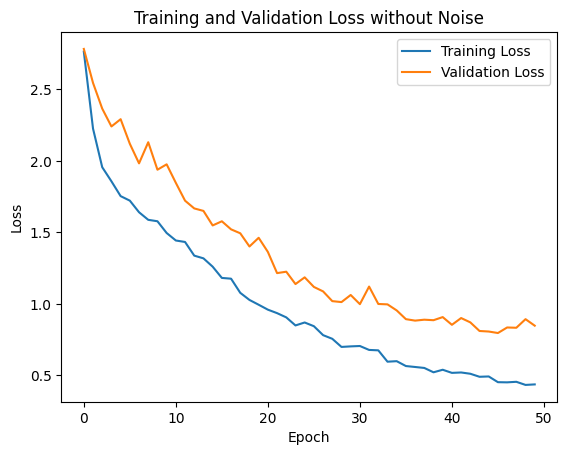

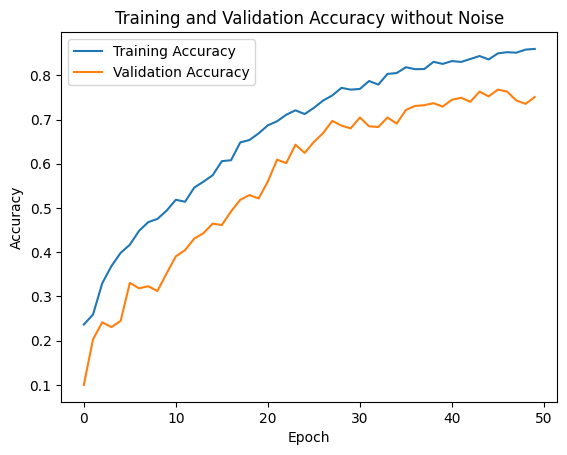

In [ ]:
import matplotlib.pyplot as plt

# Access the loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss without Noise')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy without Noise')
plt.legend()
plt.show()